<a href="https://colab.research.google.com/github/du-hr/CrowdCounter/blob/main/Crowd_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializiation

After running this cell, the runtime *must* be restarted:

In [ ]:
#Initialization of Detectron2 + restart runtime
!pip install pyyaml==5.1
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib import cm
import cv2
import numpy as np
import scipy as sci
import pandas as pd
from google.colab import drive
from sklearn import svm
from skimage.util.shape import view_as_blocks
from skimage.util.shape import view_as_windows

drive.mount('/content/drive')
path = '/content/drive/My Drive/frames/frames/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Importing Dataset

If you are using the provided datasetGray file, use this cell instead of the following two cells:

In [ ]:
#Read the datasetGray ndarray instead of importing every image
#datasetGray = np.load('/content/drive/My Drive/datasetGray.npz')['arr_0']

Obtaining the datasetGray array through iteration:

In [ ]:
 images = []

 # load seq_000001.jpg to seq_000009.jpg
 for i in range(9):
   path_i = path + 'seq_00000' + str(i+1) +'.jpg'
   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

 # load seq_000010.jpg to seq_000099.jpg
 for i in range(9,99):
   path_i = path + 'seq_0000' + str(i+1) +'.jpg'
   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

 # load seq_000100.jpg to seq_000999.jpg
 for i in range(99,999):
   path_i = path + 'seq_000' + str(i+1) +'.jpg'
   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

 # load seq_001000.jpg to seq_002000.jpg
 for i in range(999,2000):
   path_i = path + 'seq_00' + str(i+1) +'.jpg'
   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

Saving the datasetGray array to drive:

In [ ]:
datasetGray = np.asarray(images)
np.savez('/content/drive/My Drive/datasetGray.npz', datasetGray)

# Detectron2 Configuration

In [ ]:
#Configure the detector
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Using Detectron2 to Create Training Data

If you are using the provided train_images and train_labels files, use this cell and skip the rest of the section:

In [ ]:
#Loading training images 
#train_images = np.load('/content/drive/My Drive/train_images.npz', allow_pickle=True)['arr_0']
#Loading train_labels
#train_labels = np.load('/content/drive/My Drive/train_labels.npz')['arr_0']

Example image of Detectron2 detection on mall dataset:

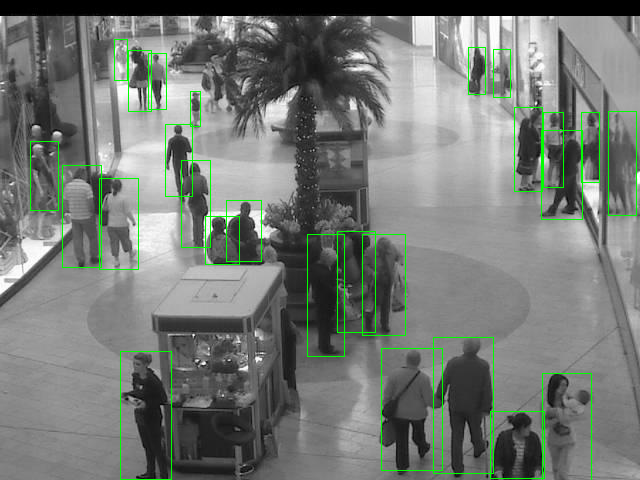

In [ ]:
datasetGrayCopy = datasetGray.copy()

testImage = cv2.cvtColor(datasetGrayCopy[0], cv2.COLOR_GRAY2RGB)
outputs = predictor(testImage)

# box is defined by its top left corner and bottom right corner
boxes_object = outputs["instances"].pred_boxes.clone()
# class 0 is a person
classes_list = outputs["instances"].pred_classes.tolist()

# extract top left corner point and bottom right corner point 
# of every box from Boxes object 
boxesOfPerson_list = []

for p,j in enumerate(boxes_object.__iter__()):
  # only consider boxes with person class
  if classes_list[p] == 0:
    boxesOfPerson_list.append(j.tolist())
    loc = (int(j[0]), int(j[1]))
    loc2 = (int(j[2]), int(j[3]))
    cv2.rectangle(testImage,loc, loc2, (0,255,0), 1)
boxesOfPerson = np.array(boxesOfPerson_list)
cv2_imshow(testImage)

Getting images of people by cropping out the images from the people recognized by the Detectron2 RCNN R50 FPN detector:

Getting images of non-people with a sliding window and making sure that the windows do not intersect people described above:

In [ ]:
#Window Size
windowSize = 40

person_images = [] # list that contains all of the person images for the training
not_person_images = [] # list that contains all of the non-person images for the training

datasetGrayCopy = datasetGray.copy()

# 10 SURVEILLANCE IMAGES
for p in range(0, 2000, 5): 
  #Get test image from the dataset
  im = cv2.cvtColor(datasetGrayCopy[p], cv2.COLOR_GRAY2RGB)
  outputs = predictor(im)

  # box is defined by its top left corner and bottom right corner
  boxes_object = outputs["instances"].pred_boxes.clone()
  # class 0 is a person
  classes_list = outputs["instances"].pred_classes.tolist()

  # extract top left corner point and bottom right corner point 
  # of every box from Boxes object 
  boxesOfPerson_list = []

  for i,j in enumerate(boxes_object.__iter__()):
    # only consider boxes with person class
    if classes_list[i] == 0:
      boxesOfPerson_list.append(j.tolist())
  boxesOfPerson = np.array(boxesOfPerson_list)

  person_images_list = [] # list of 2D person images that were cropped out

  # crop out the people from image
  for k in range(boxesOfPerson.shape[0]):
    box = boxesOfPerson[k]
    width = int(box[2] - box[0] + 1)
    crop_img = im[int(box[1]):int(box[1])+width, int(box[0]):int(box[0])+width]
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
    person_images_list.append(crop_img)
  
  person_images = person_images + person_images_list
  
  #Now we have the list of people in the image, get images without people
  step = 2*int(windowSize/3)

  #Get every single thing thats not a person
  notPeople = []

  peopleAndNotPeople = view_as_windows(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), (windowSize,windowSize), step)
  peopleAndNotPeople = np.reshape(peopleAndNotPeople, (-1, windowSize, windowSize))
  for i, window in enumerate(peopleAndNotPeople):
    isPerson = False
    location = ((i%47)*step, (i//47*step))
    x = location[0]
    y = location[1]
    w = windowSize
    for p in boxesOfPerson:
      #If a corner of person is in random window, cancel (4 corners = 4 cases)
      if x < p[0] and y < p[1] and x+w > p[0] and y+w > p[1]: isPerson = True
      elif x+w > p[0]+w and y < p[1] and x < p[0]+w and y+w > p[1]: isPerson = True
      elif x < p[0] and y+w > p[3] and x+w > p[0] and y < p[1]+w: isPerson = True
      elif x < p[0]+w and y < p[1]+w and x+w < p[2] and y+w > p[1]+w: isPerson = True        
      elif x < p[0] and y < p[1] and x+w > p[0]+w and y+w > p[1]+w: isPerson = True
      #If a corner of random window is in person, cancel (4 corners = 4 cases)
      elif p[0]+w > x+w and p[1] < y and p[0] < x+w and p[1]+w > y: isPerson = True
      elif p[0] < x and p[1] < y and p[0]+w > x and p[1]+w > y: isPerson = True
      elif p[0]+w > x and p[1] < y+w and p[0] < x and p[1]+w > y+w: isPerson = True
      elif p[0] < x+w and p[1] < y+w and p[0]+w > x+w and p[1]+w > y+w: isPerson = True
      #None of the corners interact, but the images still touch (2 cases, if one doesnt work then the other shouldnt either)
      elif x < p[0] and y > p[1] and x < p[0]+w and y < p[1]+w and x+w > p[0] and y+w > p[1] and x+w > p[0]+w and y+w < p[1]+w: isPerson = True
      elif p[0] < x and p[1] > y and p[0] < x+w and p[1] < y+w and p[0]+w > x and p[1]+w > y and p[0]+w > x+w and p[1]+w < y+w: isPerson = True

    if not isPerson:
      notPeople.append(window)

  not_person_images = not_person_images + notPeople

In [ ]:
#Generating train labels and train images
# TRAIN IMAGES (from only one surveillance image)
train_images = person_images + not_person_images

# TRAIN LABELS (from only one surveillance image)
labels_person = np.array([1] * len(person_images)) # person patches have a label of 1
labels_not_person = np.array([0] * len(not_person_images)) # not person patches have a label of 0
train_labels = np.concatenate((labels_person, labels_not_person))

Resizing the train_images for proper HoG feature generation:

In [ ]:
#adding padding to the images to train
def pad(image, globalMaxWidth, globalMaxHeight):
    result = np.zeros((globalMaxWidth, globalMaxWidth))
    result = Image.fromarray(np.uint8(result))
    image = Image.fromarray(np.uint8(image))
    result.paste(image, (0, 0))
    result = np.array(result)
    return result


#Based on the max height and width, we need to pad each image with 0's
def resize(image_list):
  resizedList = []
  for i in image_list :
    shrinkAmount = 100*windowSize/len(i)
    width = int(i.shape[1] * shrinkAmount / 100)
    height = int(i.shape[0] * shrinkAmount / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(i, dim, interpolation = cv2.INTER_AREA)
    resized_img = pad(resized, windowSize, windowSize)
    resizedList.append(resized_img)
  return np.array(resizedList)

#Start of SVM Classifier
train_images = resize(train_images)

Saving the train_images and train_labels so we do not need to generate them every time:

In [ ]:
np.savez('/content/drive/My Drive/train_images', train_images)
np.savez('/content/drive/My Drive/train_labels', train_labels)

# Training the SVM

Getting HoG Features for training:

In [ ]:
windowSize = 40

def HoGFeatures(image_list,img_size, cell_size, block_size, nbins):
  #Creating the HOGDescriptor
  hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
  features = []
  image_list = np.asarray(image_list)
  for i in image_list :
    features.append(hog.compute((i*255).astype(np.uint8)).reshape(1, -1)) #Appending the hogFeatures
  features = np.vstack(features)
  return features


trainFeatures = HoGFeatures(train_images, (windowSize,windowSize), (8,8), (4,4), 4)

Fitting a non-linear SVM classifier:

In [ ]:
#Fitting a non-linear SVM classifier
clf = svm.SVC(gamma='auto', C=700, random_state=None) #Need to change the parameters
clf.fit(trainFeatures ,train_labels)

SVC(C=700, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Using the Trained SVM to Detect People

Go through the test images by using a sliding window and obtaining the HoG features of each window. If the SVM detects a person at this location, we take note of the location.

In [ ]:
step = int(windowSize/3)

#Sliding Window
listOfWindows = []
listOfLocations = []

datasetGrayCopy = datasetGray.copy()

for originalImage in datasetGrayCopy[:10]:
  blocks = view_as_windows(originalImage, (windowSize,windowSize), step)
  blocks = np.reshape(blocks, (-1, windowSize, windowSize))
  blockFeatures = HoGFeatures(blocks, (windowSize,windowSize), (8,8), (4,4), 4)
  predictions = clf.predict(blockFeatures)
  locations = []
    

    #Taking note of locations of each person detected
  for i in range(len(predictions)):
    if predictions[i] == 1:
      locations.append(((i%47)*step, (i//47*step), ((i%47)*step)+windowSize, (i//47*step)+windowSize ))
  listOfLocations.append(locations)
  listOfWindows.append(predictions)

Drawing bounding boxes on detected people (duplicates not removed yet):

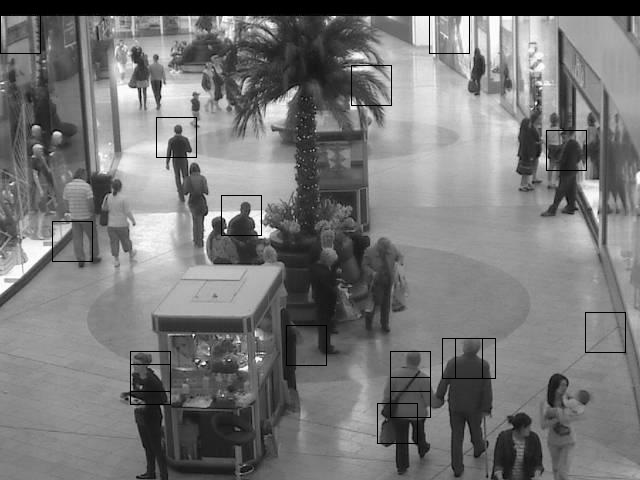

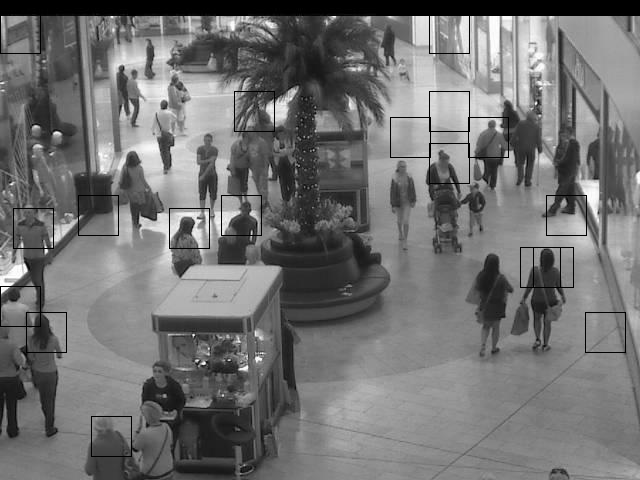

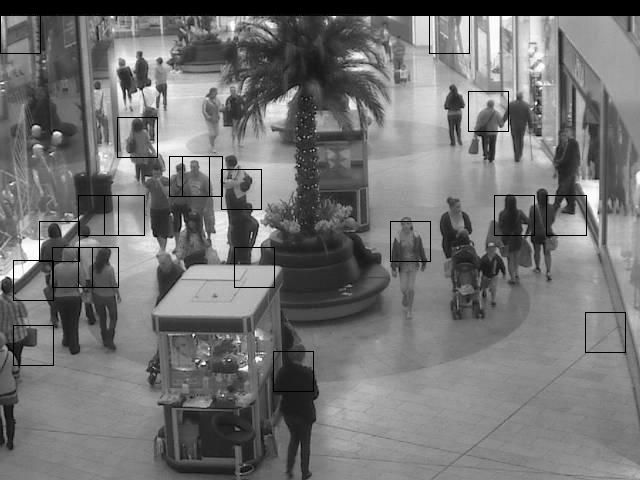

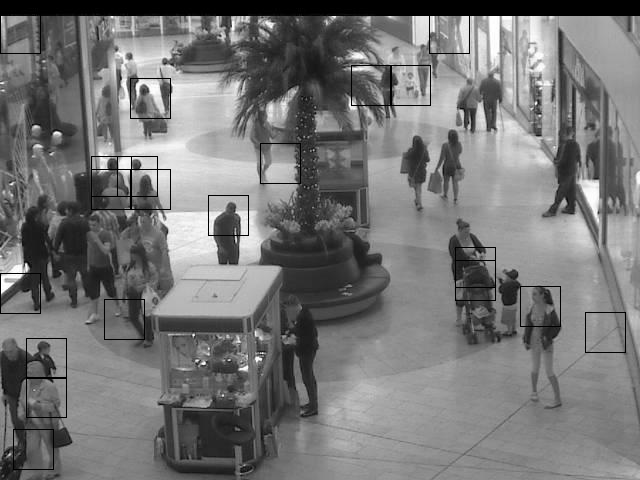

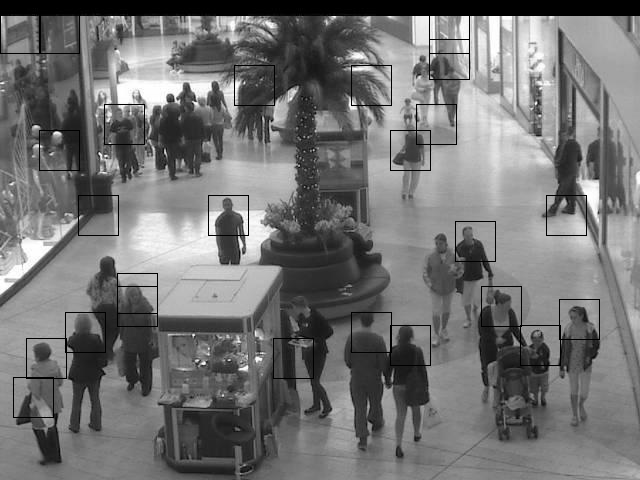

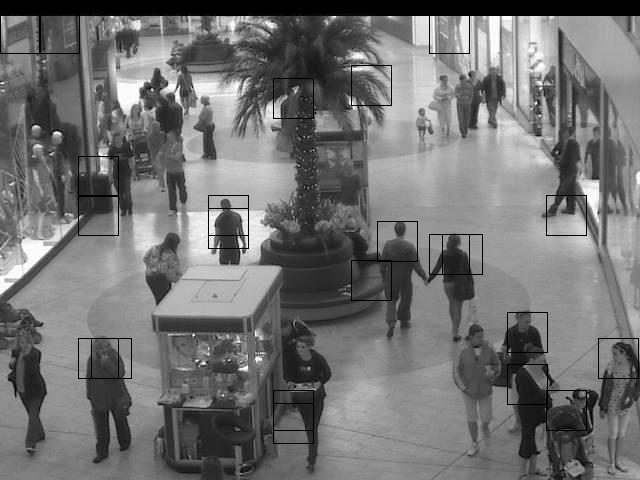

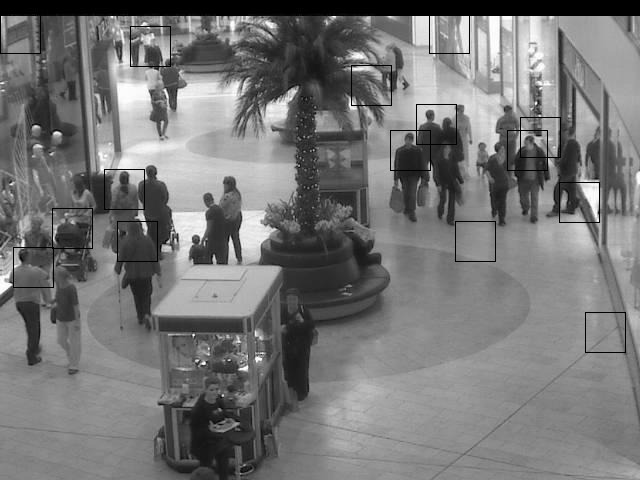

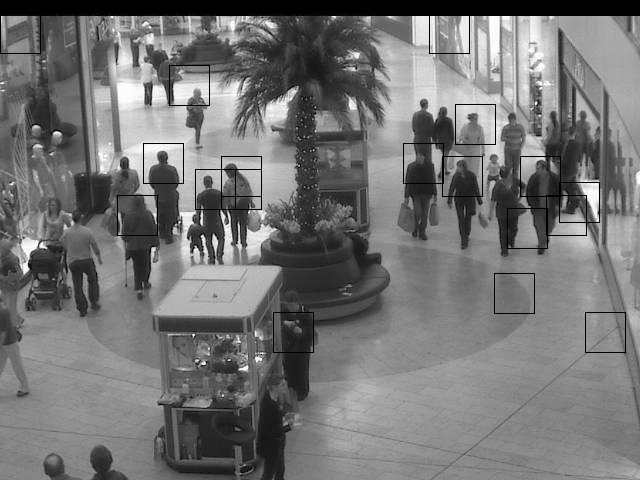

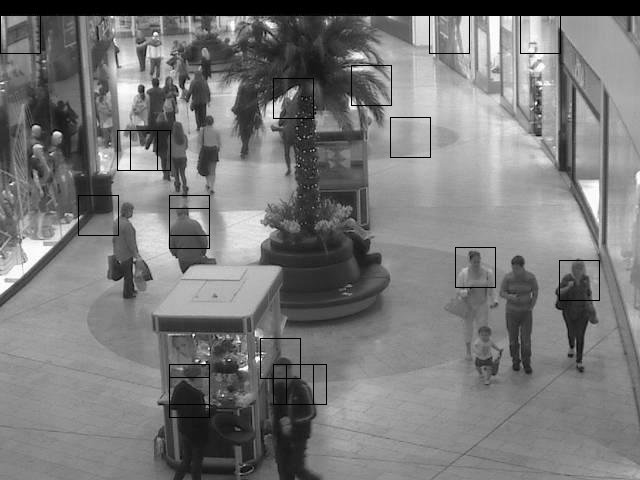

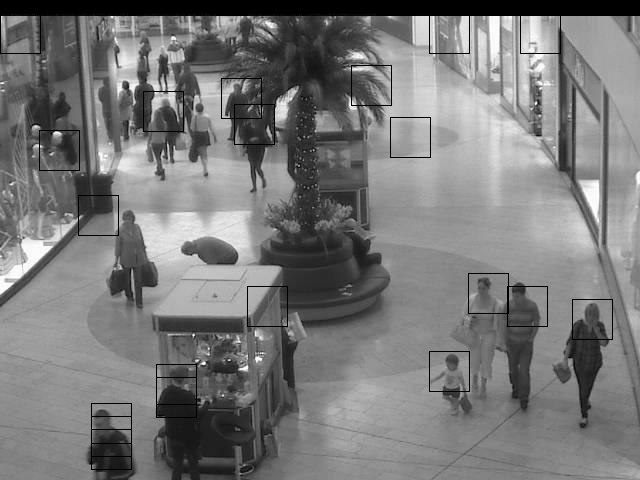

In [ ]:
from PIL import Image
from matplotlib import cm

datasetGrayCopy = datasetGray.copy()


#Drawing the locations on the image for testing before bounding boxes
dotImages = []
image = 0
for i, image in enumerate(datasetGrayCopy[:10]):
  for box in listOfLocations[i]:
    loc = (box[0],box[1])
    loc2 = (box[2], box[3])
    #loc2 = (loc[0]+windowSize, loc[1]+windowSize)
    cv2.rectangle(image,loc, loc2, (0,255,0), 1)
  dotImages.append(image) 


for image in dotImages:
  cv2_imshow(image)

Removing duplicates:

In [ ]:
# function that computes the Intersection-over-union (IoU)
#boxA and boxB = tuple location
def find_IoU(boxA, boxB):
  # NUMERATOR
  # determine the top left corner of the intersection rectangle
  x_tlc = max(boxA[0], boxB[0])
  y_tlc = max(boxA[1], boxB[1])
  # determine the bottom right corner of the intersection rectangle
  x_brc = min(boxA[2], boxB[2])
  y_brc = min(boxA[3], boxB[3])
  # calculate the area of overlap between the predicted bounding box and the ground-truth bounding box
  overlap_area = max(0, x_brc - x_tlc + 1) * max(0, y_brc - y_tlc + 1)
  
  # DENOMINATOR
  # calculate the area of the predicted bounding box and the area of the ground-truth bounding box separately
  boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # calculate the  area of union
  # i.e., the area encompassed by both the predicted bounding box and the ground-truth bounding box
  union_area = boxA_area + boxB_area - overlap_area
  
  # IoU
  # compute the intersection over union
  iou = overlap_area / float(union_area)
  return iou

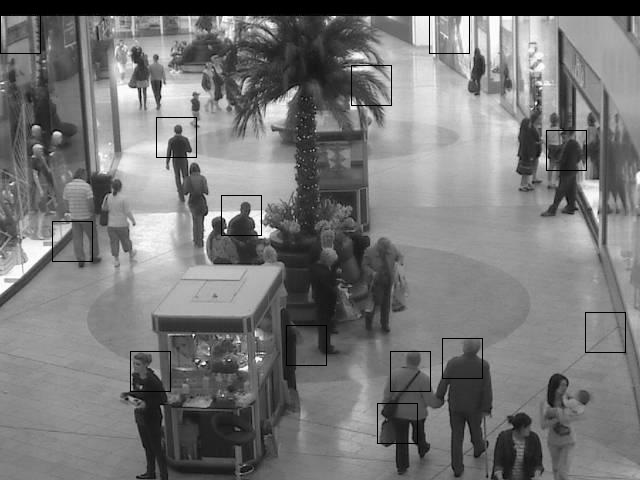

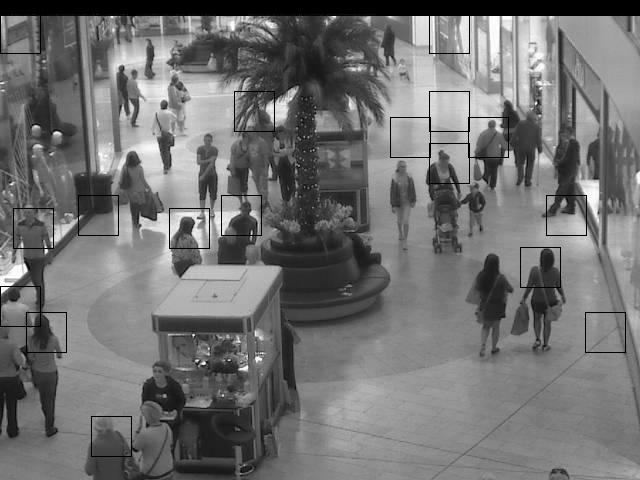

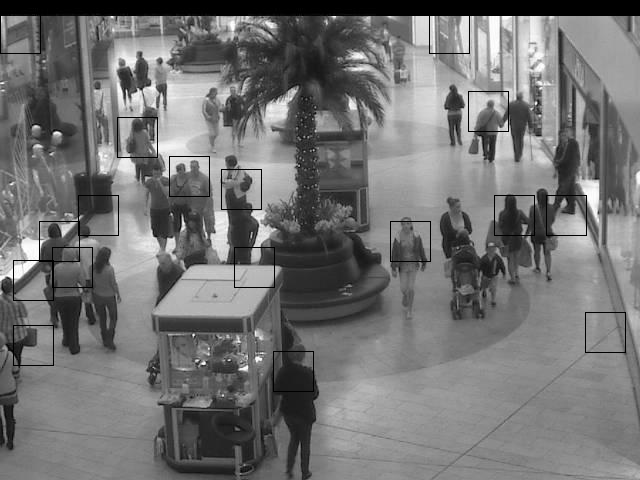

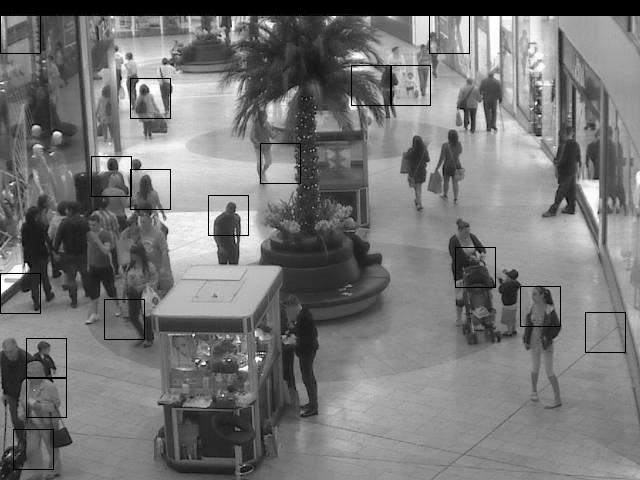

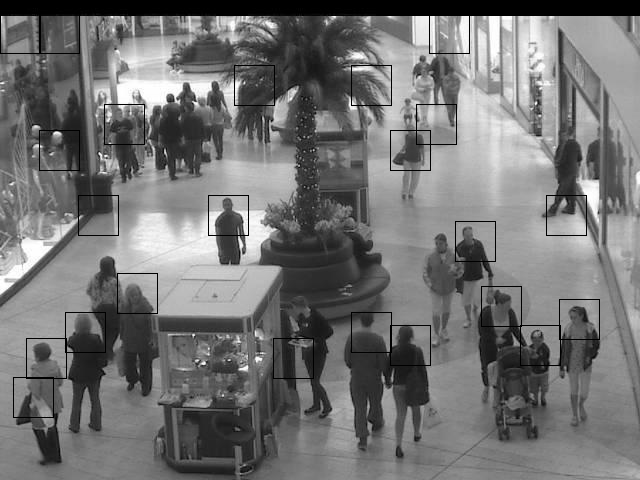

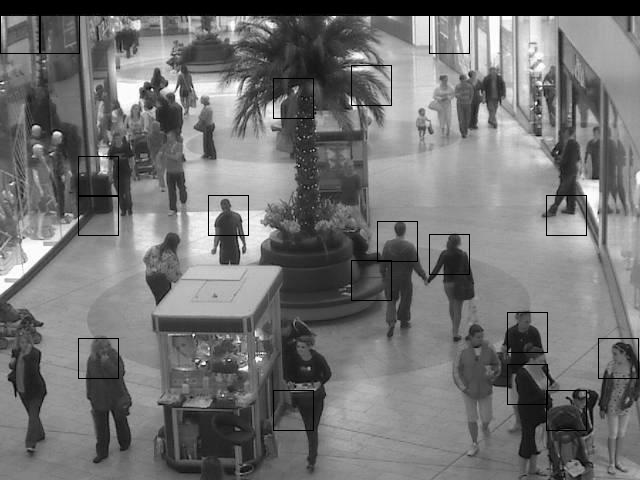

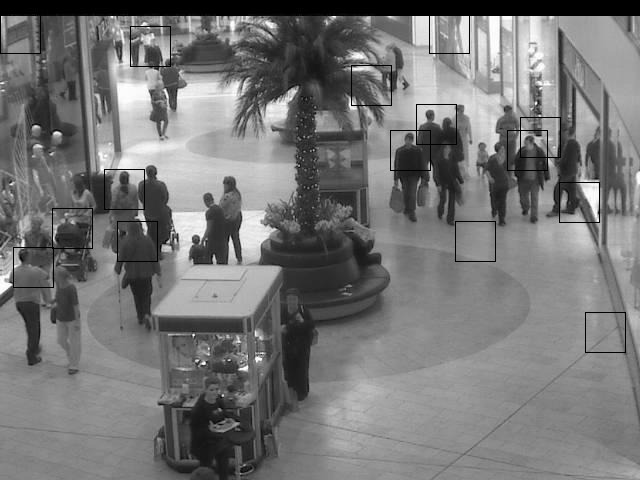

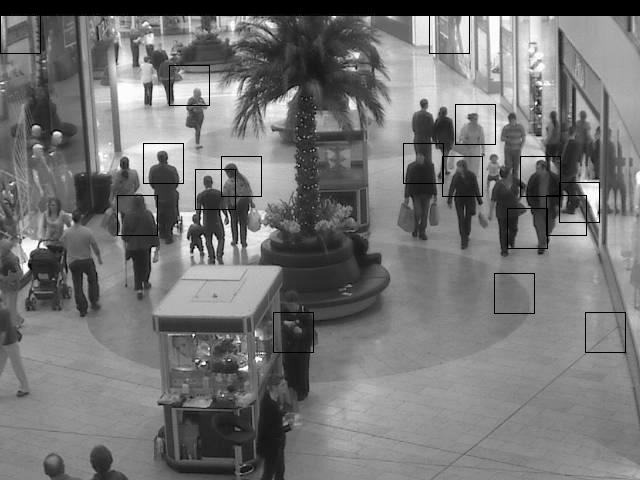

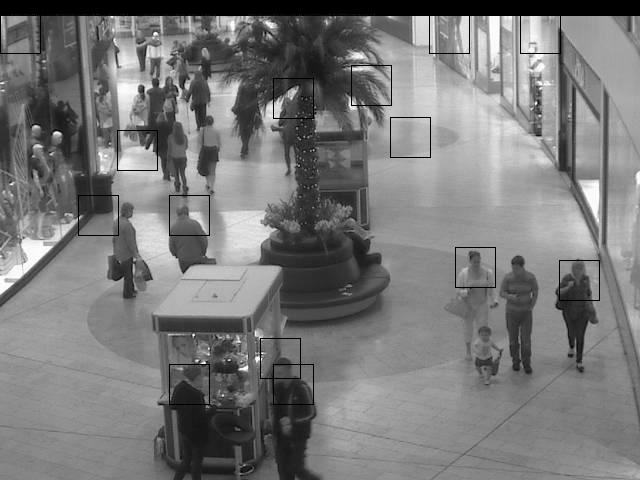

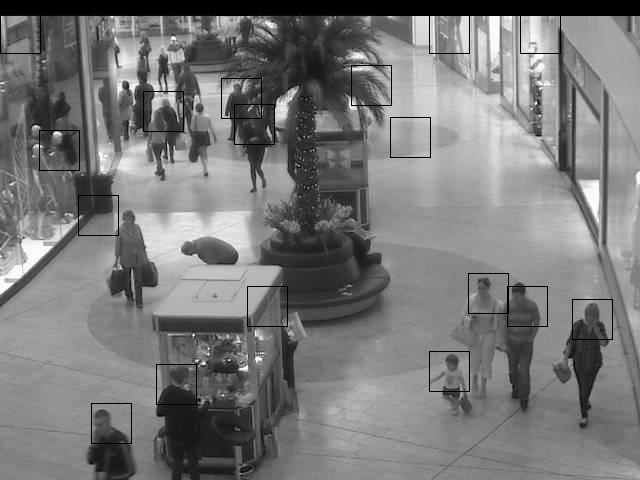

In [ ]:
thresholdX = 0.1
thresholdY = 30

listOfLocations2 = []
for locations in listOfLocations:
  for i, square in enumerate(locations):

    #Fix duplicates in x axis
    firstSquare = square
    secondSquare = (0, 0, 0, 0)
    if i == len(locations)-1: continue
    else:
      secondSquare = locations[i+1]
    if (find_IoU(secondSquare, firstSquare) > thresholdX):
      locations[i] = firstSquare
      locations[i+1] = firstSquare

    #Fix duplicates in y axis
    firstSquare = square
    for j in range(i+1, len(locations)):
      potentialOverlap = locations[j]
      #Must satisfy these conditions:
      yValuesDifference = abs(firstSquare[1] - potentialOverlap[1])
      if firstSquare[0]==potentialOverlap[0] and yValuesDifference < thresholdY:
        #Only keep the first square
        locations[j] = firstSquare

  listOfLocations2.append(locations)

datasetGrayCopy = datasetGray.copy()

#Drawing the bounding boxes on the image 
dotImages = []
image = 0
for i, image in enumerate(datasetGrayCopy[:10]):
  for box in listOfLocations2[i]:
    loc = (box[0],box[1])
    loc2 = (box[2], box[3])
    #loc2 = (loc[0]+windowSize, loc[1]+windowSize)
    cv2.rectangle(image,loc, loc2, (0,255,0), 1)
  dotImages.append(image) 


for image in dotImages:
  cv2_imshow(image)

# Accuracy Metrics

Locations using the Detectron2:

In [ ]:
#Configure the detector
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

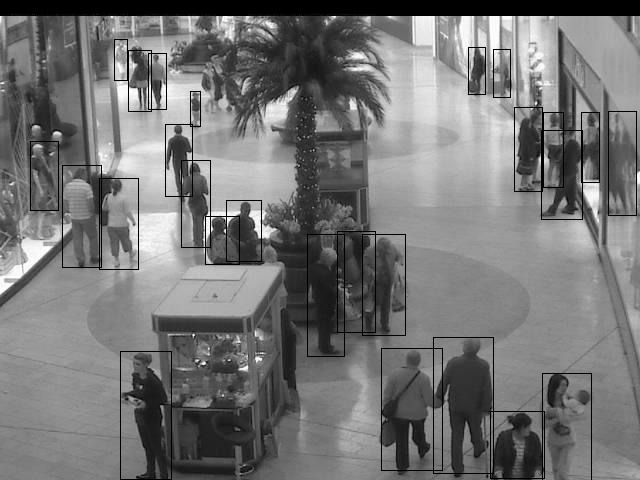

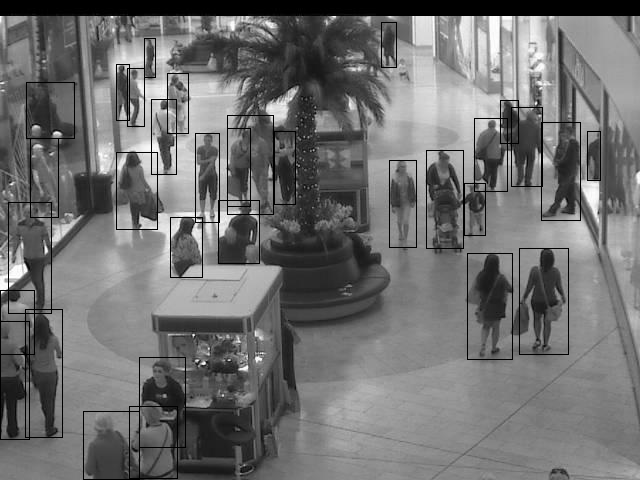

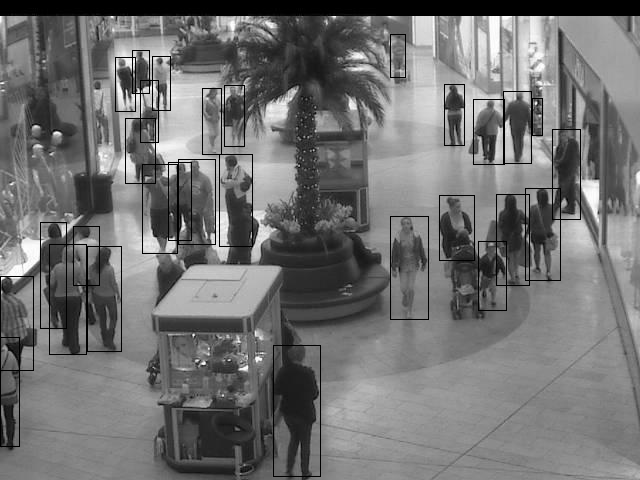

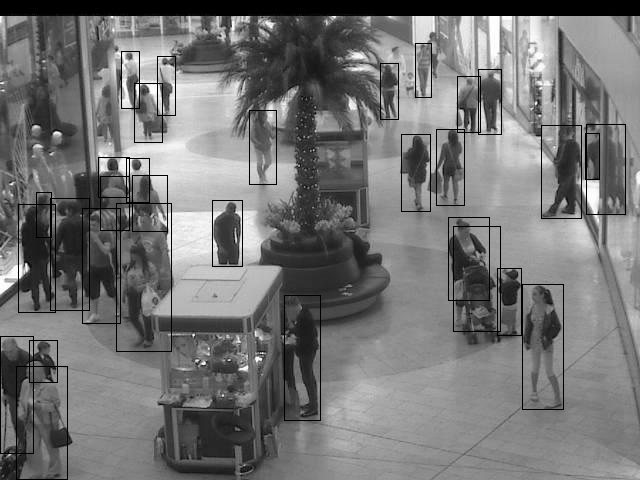

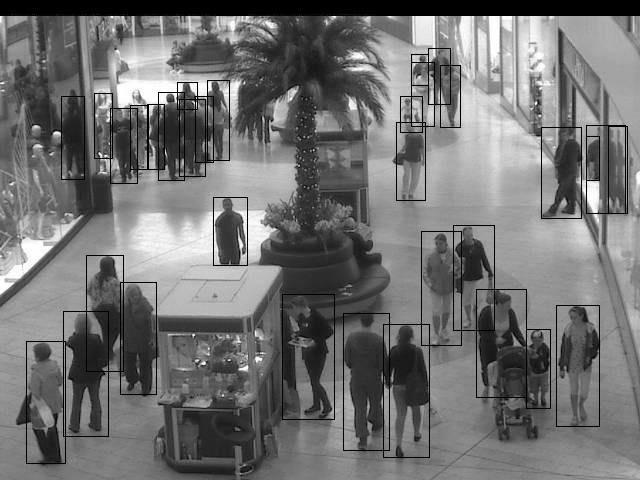

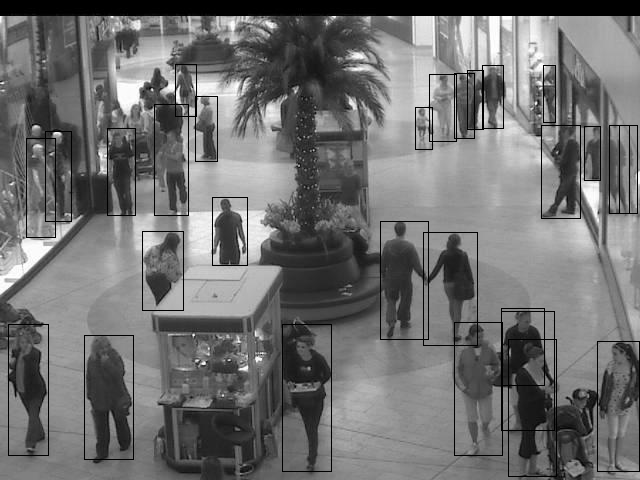

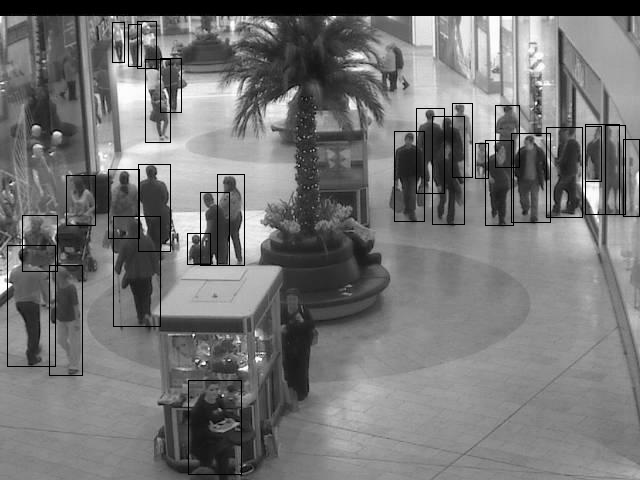

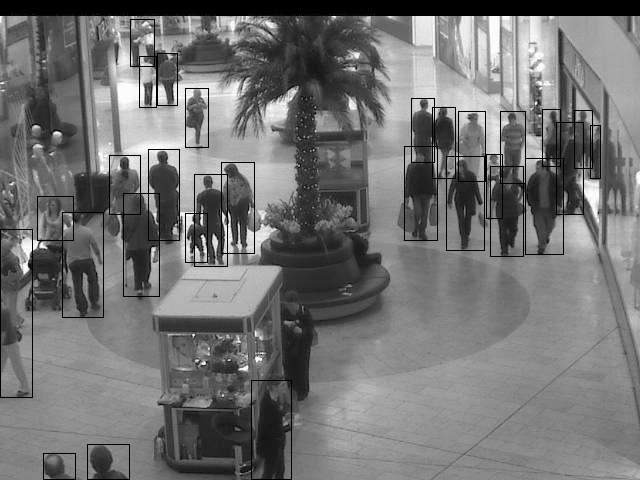

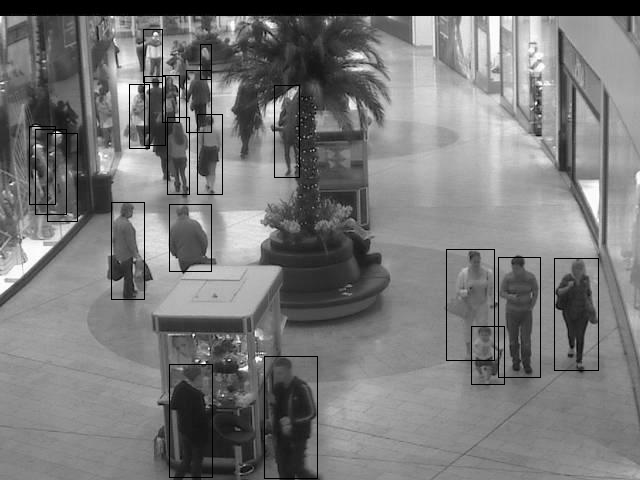

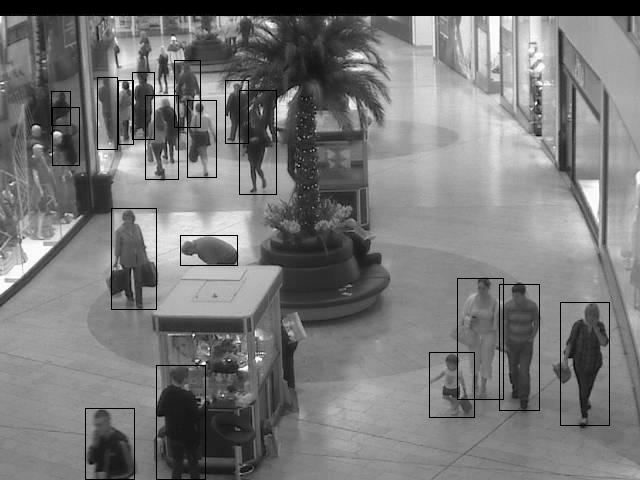

In [ ]:
numberOfImages = 10

windowSize = 40
datasetGray = np.load('/content/drive/My Drive/datasetGray.npz')['arr_0']
datasetGrayCopy = datasetGray.copy()

detectron2Locations = []

for i in range(numberOfImages):
  #Get test image from the dataset
  im = cv2.cvtColor(datasetGrayCopy[i], cv2.COLOR_GRAY2RGB)
  outputs = predictor(im)

  # box is defined by its top left corner and bottom right corner
  boxes_object = outputs["instances"].pred_boxes.clone()
  # class 0 is a person
  classes_list = outputs["instances"].pred_classes.tolist()

  # extract top left corner point and bottom right corner point 
  # of every box from Boxes object 
  boxesOfPerson_list = []

  for p,j in enumerate(boxes_object.__iter__()):
    # only consider boxes with person class
    if classes_list[p] == 0:
      boxesOfPerson_list.append(j.tolist())
      loc = (int(j[0]), int(j[1]))
      loc2 = (int(j[2]), int(j[3]))
      cv2.rectangle(datasetGrayCopy[i],loc, loc2, (0,255,0), 1)
  boxesOfPerson = np.array(boxesOfPerson_list)
  detectron2Locations.append(boxesOfPerson)
  cv2_imshow(datasetGrayCopy[i])

#detectron2Locations is a list of ndarrays

Locations using our SVM:

In [ ]:
step = int(windowSize/3)

#Sliding Window
listOfWindows = []
listOfLocations = []

datasetGrayCopy = datasetGray.copy()

for originalImage in datasetGrayCopy[:numberOfImages]:
  blocks = view_as_windows(originalImage, (windowSize,windowSize), step)
  blocks = np.reshape(blocks, (-1, windowSize, windowSize))
  blockFeatures = HoGFeatures(blocks, (windowSize,windowSize), (8,8), (4,4), 4)
  predictions = clf.predict(blockFeatures)
  locations = []
    

    #Taking note of locations of each person detected
  for i in range(len(predictions)):
    if predictions[i] == 1:
      locations.append(((i%47)*step, (i//47*step), ((i%47)*step)+windowSize, (i//47*step)+windowSize ))
  listOfLocations.append(locations)
  listOfWindows.append(predictions)



thresholdX = 0.1
thresholdY = 30

listOfLocations2 = []
for locations in listOfLocations:
  for i, square in enumerate(locations):

    #Fix duplicates in x axis
    firstSquare = square
    secondSquare = (0, 0, 0, 0)
    if i == len(locations)-1: continue
    else:
      secondSquare = locations[i+1]
    if (find_IoU(secondSquare, firstSquare) > thresholdX):
      locations[i] = firstSquare
      locations[i+1] = firstSquare

    #Fix duplicates in y axis
    firstSquare = square
    for j in range(i+1, len(locations)):
      potentialOverlap = locations[j]
      #Must satisfy these conditions:
      yValuesDifference = abs(firstSquare[1] - potentialOverlap[1])
      if firstSquare[0]==potentialOverlap[0] and yValuesDifference < thresholdY:
        #Only keep the first square
        locations[j] = firstSquare

  listOfLocations2.append(np.array(locations))

SVMLocations = listOfLocations2

#Drawing the bounding boxes on the image 
dotImages = []
image = 0
for i, image in enumerate(datasetGrayCopy[:10]):
  for box in listOfLocations2[i]:
    loc = (box[0],box[1])
    loc2 = (box[2], box[3])
    #loc2 = (loc[0]+windowSize, loc[1]+windowSize)
    cv2.rectangle(image,loc, loc2, (0,255,0), 1)
  dotImages.append(image) 


for image in dotImages:
  cv2_imshow(image)
#SVMLocations is a list of ndarrays

Finding which locations match from the two detectors and applying Intersection by Union:

In [ ]:

meanIOU = 0

for l in range(len(detectron2Locations)):
  image_meanIOU = 0
  for D2Box in detectron2Locations[l]:
    x = D2Box[0]
    w = abs(D2Box[0] - D2Box[2])
    y = D2Box[1]
    h = abs(D2Box[1] - D2Box[3])
    for p in SVMLocations[l]:
        #If a corner of D2box is in the SVMBox (4 corners = 4 cases)
        if x < p[0] and y < p[1] and x+w > p[0] and y+h > p[1]:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break
        elif x+w > p[0]+w and y < p[1] and x < p[0]+w and y+h > p[1]:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break
        elif x < p[0] and y+h > p[3] and x+w > p[0] and y < p[1]+w:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break
        elif x < p[0]+w and y < p[1]+w and x+w < p[2] and y+h > p[1]+w:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break  
        elif x < p[0] and y < p[1] and x+w > p[0]+w and y+h > p[1]+w:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break
        #If a corner of the SVMBox is in D2Box (4 corners = 4 cases)
        elif p[0]+w > x+w and p[1] < y and p[0] < x+w and p[1]+w > y:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box)
          break
        elif p[0] < x and p[1] < y and p[0]+w > x and p[1]+w > y:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box) 
          break
        elif p[0]+w > x and p[1] < y+h and p[0] < x and p[1]+w > y+h:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box) 
          break
        elif p[0] < x+w and p[1] < y+h and p[0]+w > x+w and p[1]+w > y+h:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box) 
          break
        #None of the corners interact, but the boxes still touch (2 cases, if one doesnt work then the other shouldnt either)
        elif x < p[0] and y > p[1] and x < p[0]+w and y < p[1]+w and x+w > p[0] and y+h > p[1] and x+w > p[0]+w and y+h < p[1]+w:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box) 
          break
        elif p[0] < x and p[1] > y and p[0] < x+w and p[1] < y+h and p[0]+w > x and p[1]+w > y and p[0]+w > x+w and p[1]+w < y+h:
          image_meanIOU = image_meanIOU + find_IoU(p, D2Box) 
          break
  image_meanIOU = image_meanIOU/len(SVMLocations[l])
  meanIOU = meanIOU + image_meanIOU

meanIOU = meanIOU/len(SVMLocations)

For the IoU measurement, we obtained an IoU metric for each bounding box match in each test image, then we took the average of that for each bounding box match in the image and this gave us an average IoU metric for each image (image_meanIOU). Next, we took the average of this metric for each test image use for accuracy measurement and this value was 0.10246 (meanIOU)

# Creating Submission File for Kaggle

In [ ]:
import csv

row_list = [['id', 'count']]
for i, people in enumerate(listOfLocations2):
  sum = len(people)
  row = [i+1, sum]
  row_list.append(row)

with open('/content/drive/My Drive/submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)